# Histopathologic Cancer Detection
## A complete ML pipeline(Fast.ai) 따라하기
https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai

## Sections of this kernel
 1. Project understanding
 - Data understanding
 - Data Visualization
 - Baseline model (Fastai v1)
 - Validation and analysis
  - Metrics
  - Prediction and activation Visualization
  - ROC & AUC
 - Submit
 - Deploy(example)
 
<font color='blue'>deploy 1. (군대·무기를) 배치하다   2. 효율적으로 사용하다</font>

# 1. Project understanidng

Binary image classification problem.
96 x 96px digital histopathology images.
### How would a solution look like?
Our evaluation metric is area under the ROC curve.

cf) 
ROC(Receiver Operating Characteristic) Curve <br>
=> 수신기 조작 특성 곡선 (2진 분류에서 많이 사용)<br><br>
<br><font size=5>
$ROC = \frac{TPR}{FPR}$<br><br>
$TPR(True Positive Rate) = Recall(재현율) = \frac{TP}{TP + FN}$<br><br>
$FPR(False Positive Rate) = \frac{FP}{FP + TN} = \frac{FP + TN - TN}{FP + TN} = 1- \frac{TN}{FP + TN} = 1 - TNR$<br><br>
 
<table class="tg">
  <tr>
    <th class="tg-c3ow"></th>
    <th class="tg-c3ow"></th>
    <th class="tg-c3ow">예측</th>
    <th class="tg-c3ow"></th>
  </tr>
  <tr>
    <td class="tg-c3ow"></td>
    <td class="tg-c3ow"></td>
    <td class="tg-c3ow">음성</td>
    <td class="tg-c3ow">양성</td>
  </tr>
  <tr>
    <td class="tg-c3ow"><b>실제</b></td>
    <td class="tg-c3ow">음성</td>
    <td class="tg-c3ow">TN(True Negative)</td>
    <td class="tg-c3ow">FP(False Positive)</td>
  </tr>
  <tr>
    <td class="tg-c3ow"></td>
    <td class="tg-c3ow">양성</td>
    <td class="tg-c3ow">FN(False Negative)</td>
    <td class="tg-c3ow">TP(True Positive)</td>
  </tr>
</table>
<br><br>
</font>
$Precision = \frac{TP}{TP + FP}$<br><br>

TPR이 높을 수록 FPR이 늘어난다.<br>
좋은 분류기는 완전한 랜덤 분류기 y=x 그래프로부터 최대한 멀리 떨어져야 한다.(왼쪽 위 모서리에 바짝 붙음)<br>
AUC(Area Under the Curve) : 곡선 아래 면적<br>
완벽한 분류기는 ROC의 AUC = 1<br>
완전한 랜덤 분류기 = 0.5<br>




## What is known about the domain?
The histopathological images are glass slide microscope images of lymph nodes that are stained with hematoxylin and eosin (H&E).

<font color='blue'>stain with …로 더럽히다<br>
hematoxylin(헤마톡실린) : 세포핵을 얼룩지게 하기 때문에 여전히 염색 조직 제조에 있어 매우 중요하다. 헤마톡실린은 또한 분석 화학에서 매우 중요하며 색체 검출과 다양한 금속과 암모니아의 정량 분석에 사용된다.<br>

hematoxylin and eosin(헤마톡실린-에오신) : 조직 관찰을 위한 염색색소로, 핵은 헤마톡실린에 의해 남색으로, 세포질은 에오신에 의해 담홍색으로 염색된다.
<br>
sentinel lymph node (감시림프절) : primary tumor에서 lympathic drainage를 받는 첫번째 lymph node. 종양이 있는 부위에서 림프절로 림프액이 나가는 길을 따라 갔을 때 있는 첫번째 림프절. 왜 중요하냐 하면 이것을 보고 수술을 어떻게 할까를 결정하는데 도움이 되기 떄문입니다.
</font>

## Useful links for background knowledge

- Patch Camelyon (PCam) : https://github.com/basveeling/pcam
- Hematoxylin and eosin staining of tissue and cell sections : https://www.ncbi.nlm.nih.gov/pubmed/21356829
- H&E-stained sentinel lymph node sections of breast cancer patients: the CAMELYON dataset
  - https://academic.oup.com/gigascience/article/7/6/giy065/5026175
- CAMELYON16 - background : https://camelyon16.grand-challenge.org/Background/
- CAMELYON17 - background : https://camelyon17.grand-challenge.org/Background/
- TNM classification : https://www.uicc.org/resources/tnm

# 2. Data understanding
## What data do we have available?
220k training images and 57k evaluation images. The dataset is a subset of the PCam dataset and the only difference between these two is that all duplicate images have been removed.

# 3. Data Visualization

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

In [2]:
data = pd.read_csv('E:\\kaggle\\histopathologic-cancer-detection\\train_labels.csv')
train_path='E:\\kaggle\\histopathologic-cancer-detection\\train\\'
test_path='E:\\kaggle\\histopathologic-cancer-detection\\test\\'

data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

negative/positive ratio 130k/90k => 6:4

In [3]:
def readImage(path):
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

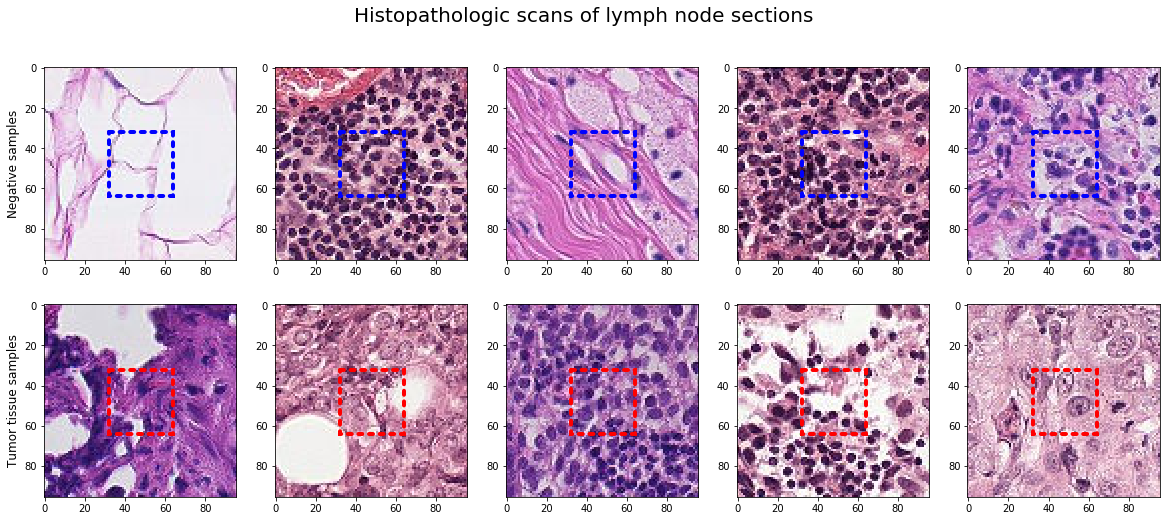

In [4]:
shuffled_data = shuffle(data)

fig,ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)

for i, idx in enumerate(shuffled_data[shuffled_data['label']==0]['id'][:5]):
    path=os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path+'.tif'))
    box = patches.Rectangle((32,32),32,32,linewidth=4, edgecolor='b', facecolor='none', 
                            linestyle=':',capstyle='round')
    ax[0,i].add_patch(box)
    
ax[0,0].set_ylabel('Negative samples', size='large')

for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

In [5]:
import random
ORIGINAL_SIZE=96

CROP_SIZE=90
RANDOM_ROTATION=3
RANDOM_SHIFT=2
RANDOM_BRIGHTNESS=7
RANDOM_CONTRAST=5
RANDOM_90_DEG_TURN=1

def readCroppedImage(path, augmentations=True):
    bgr_img=cv2.imread(path)
    b,g,r = cv2.split(bgr_img)
    rgb_img=cv2.merge([r,g,b])
    
    if(not augmentations):
        return rgb_img/255
    
    rotation = random.randint(-RANDOM_ROTATION, RANDOM_ROTATION)
    if RANDOM_90_DEG_TURN == 1:
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48), rotation, 1)
    rgb_img = cv2.warpAffine(rgb_img, M, (96,96))
    
    x=random.randint(-RANDOM_SHIFT,RANDOM_SHIFT)
    y=random.randint(-RANDOM_SHIFT,RANDOM_SHIFT)
    
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_img = rgb_img[(start_crop+x):(end_crop + x), (start_crop+y):(end_crop+y)] / 255
    
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if flip_hor:
        rgb_img = rgb_img[:,::-1]
    if flip_ver:
        rgb_img = rgb_img[::-1,:]
        
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 10.
    rgb_img = rgb_img + br
    
    cr = 1. + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    rgb_img = np.clip(rgb_img, 0, 1.)
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

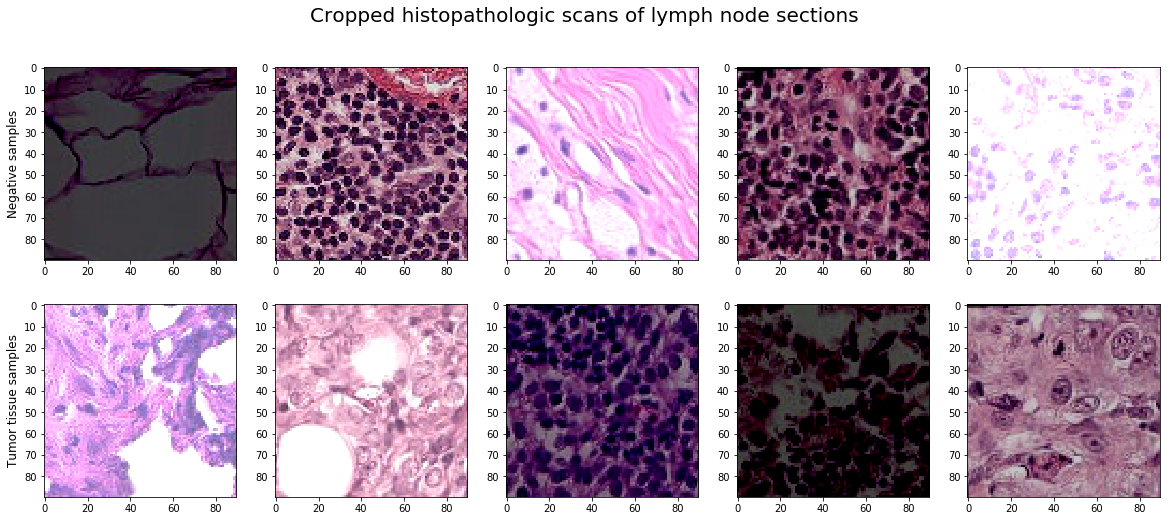

In [6]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Cropped histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif'))
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif'))
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

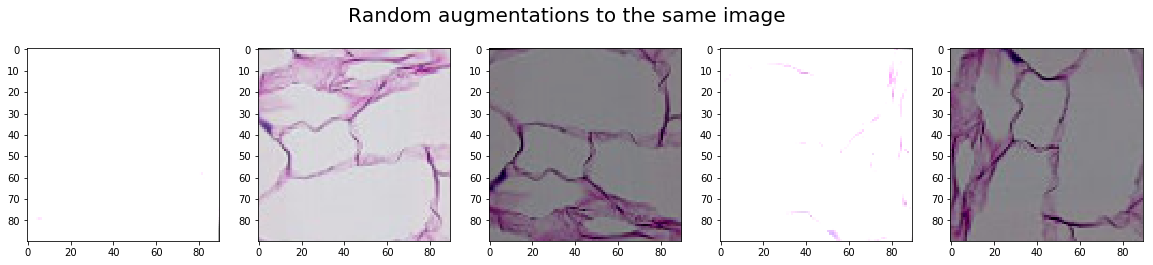

In [7]:
fig,ax=plt.subplots(1,5,figsize=(20,4))
fig.suptitle('Random augmentations to the same image', fontsize=20)

for i,idx in enumerate(shuffled_data[shuffled_data['label']==0]['id'][:1]):
    for j in range(5):
        path = os.path.join(train_path, idx)
        ax[j].imshow(readCroppedImage(path+'.tif'))